In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quadrature, quad
import numpy.random as rand
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML

from lib.lif import LIF, ParamsLIF, LIF_3layer, ParamsLSM, LSM

Populating the interactive namespace from numpy and matplotlib


## Learn XOR function

In [10]:
mm = 1000
fi_min = -6
fi_max = 50
Is = np.linspace(fi_min, fi_max, mm)
fI = np.zeros(Is.shape)
V_th = 1
V_r = 0
V_rest = 0
sigma = 20
tau_m = 1

In [11]:
for idx,I in enumerate(Is):
    y_th = (V_th - V_rest - I)/sigma
    y_r  = (V_r -  V_rest - I)/sigma
    f = lambda u: np.divide(np.multiply(np.exp(-u**2),np.exp(2*y_th*u)-np.exp(2*y_r*u)),u)
    a=quad(f, 0.1, np.infty)[0]
    if np.isfinite(a):
        fI[idx] = 1/(tau_m*a)
        
_fI_prime = np.hstack((0,np.diff(fI)))

def fI_prime(I):
    if isinstance(I, np.ndarray):
        I[I < fi_min] = fi_min
        I[I > fi_max] = fi_max
    else:
        I = float(I)
        if I < fi_min:
            I = fi_min
        if I > fi_max:
            I = fi_max
    return _fI_prime[np.ceil(mm*(I-fi_min)/(fi_max-fi_min)).astype(int)-1]

/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda/miniconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply


In [117]:
N = 500           # Number of episodes
n = 10              # Number of hidden neurons
no = 1             # Number of output neurons
q = 3               # Number of learnt parameters
tau_s = 0.20        # Time scale for output filter
mu = 1              # Threshold
p = 0.05            # Window size
t = 10               # Time for each episode
eta = .1            # RDD learning rate
epsilon = 300         # Weight learning rate
epsilon_hidden = 30   # Hidden layer learning rate
deltaT = 20         # Size of beta learning mini batches
tau = 10
sigma = 3
alpha = 50
c = 0.25

params = ParamsLIF(n = n, tau = tau, sigma = sigma, c = c)
lif = LIF_3layer(params, tau_s = tau_s, t = t, alpha = 50)

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

def xor(x):
    return x[0] != x[1]

#Simulate episode
Vo = np.zeros((1, q))
Vh = np.zeros((n, q))

inputs = [[0, 0], [0, 1], [1, 0], [1, 1]]
nI = len(inputs)

#Save learning progress
mean_cost = np.zeros(N)
mean_output = np.zeros(N)

Whist = np.zeros((lif.W.shape[0], lif.W.shape[1], N))
Uhist = np.zeros((lif.U.shape[0], lif.U.shape[1], N))
Vohist = np.zeros((Vo.shape[0], Vo.shape[1], N))
Vhhist = np.zeros((Vh.shape[0], Vh.shape[1], N))
#betahist = np.zeros((Vh.shape[0], Vh.shape[1], N))

alpha = 200
beta = -300

wmax = 20
umax = 20

x_inputs_idx = np.zeros((N))

#Simulate one second's worth
for idx in range(N):
    #Choose input at random
    x_input = np.random.rand(2)<0.5

    if x_input[0] == 0:
        if x_input[1] == 0:
            x_inputs_idx[idx] = 0
        else:
            x_inputs_idx[idx] = 1
    else:
        if x_input[1] == 0:
            x_inputs_idx[idx] = 2
        else:
            x_inputs_idx[idx] = 3

    #Cycle through inputs
    #x_input = np.array(inputs[idx%4])
    
    #Simulate system
    (vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate(x_input)

    nB = vh_full.shape[1]/deltaT
    vo = np.zeros((no, nB))
    vh = np.zeros((n, nB))
    sx = np.zeros((2, nB))
    sh = np.zeros((n, nB))
    
    so = np.convolve(ho[0,:], exp_filter)[0:ho.shape[1]]    
    #Compute cost function
    dcost = alpha if xor(x_input) else beta
    cost = dcost*so
    
    #Block into DeltaT blocks...
    #Block cost and filtered outputs function
    cost_r = cost.reshape((-1, deltaT))
    cost = np.squeeze(cost_r[:,-1])
    so_r = so.reshape((-1, deltaT))
    so = np.squeeze(so_r[:,-1])
        
    #Take max vh and vo for estimating beta
    for j in range(no):
        v_ro = vo_full[j,:].reshape((-1, deltaT))
        vo[j,:] = np.max(v_ro, 1)
    
    for j in range(n):
        v_rh = vh_full[j,:].reshape((-1, deltaT))
        vh[j,:] = np.max(v_rh, 1)
        sh_r = sh_full[j,:].reshape((-1, deltaT))
        sh[j,:] = np.squeeze(sh_r[:,-1])

    for j in range(2):
        sx_r = sx_full[j,:].reshape((-1, deltaT))
        sx[j,:] = sx_r[:,-1]
    
    #Run through and apply RDD online
    dVo = np.zeros(Vo.shape)
    dVh = np.zeros(Vh.shape)
    dW = np.zeros(lif.W.shape)
    dU = np.zeros(lif.U.shape)
    nSo = 0
    nSh = np.zeros(n)
    bto = False
    bth = [False]*n
    
    for t in range(nB):
        #Update RD weights for output neuron
        if (vo[0,t] > mu - p) & (vo[0,t] < mu):
            if bto == False:
                #ahat = np.array([1, 0, -(v[k,t]-mu)])
                ahat = np.array([1, 0, 0])
                dVo[0,:] += (np.dot(Vo[0,:], ahat)+cost[t])*ahat                    
                bto = True
        elif (vo[0,t] < mu + p) & (vo[0,t] >= mu):
            #Only do the update when firing...
            if bto == True:
                #ahat = np.array([1, 0, -(v[k,t]-mu)])
                ahat = np.array([1, 0, 0])
                dVo[0,:] += (np.dot(Vo[0,:], ahat)-cost[t])*ahat                
                Vo[0,:] = Vo[0,:] - eta*dVo[0,:]#*N/(N+1)
                dVo[0,:] = np.zeros((1,q))
                bto = False
                
        #Update weights for output layer
        if vo[0,t] > mu:
            dU[0,:] += Vo[0,0]*sh[:,t]#*fI_prime(np.dot(lif.U[0,:], sh[:,t]))
            nSo += 1
            #Or use the true gradient...
            #dU[0,:] += dcost*sh[:,t]
            #pass
                        
        for k in range(n):
            #Update RD weights for hidden neurons
            if (vh[k,t] > mu - p) & (vh[k,t] < mu):
                if bth[k] == False:
                    #ahat = np.array([1, 0, -(v[k,t]-mu)])
                    ahat = np.array([1, 0, 0])
                    dVh[k,:] += (np.dot(Vh[k,:], ahat)+cost[t])*ahat                
                    bth[k] = True
            elif (vh[k,t] < mu + p) & (vh[k,t] >= mu):
                #Only do the update when firing...
                if bth[k] == True:
                    #ahat = np.array([1, 0, -(v[k,t]-mu)])
                    ahat = np.array([1, 0, 0])
                    dVh[k,:] += (np.dot(Vh[k,:], ahat)-cost[t])*ahat                
                    Vh[k,:] = Vh[k,:] - eta*dVh[k,:]#*N/(N+1)
                    dVh[k,:] = np.zeros((1,q))
                    bth[k] = False
            #Update weights for hidden neurons
            if vh[k,t] > mu:
                #print "Updating dW"
                dW[k,:] += Vh[k,0]*sx[:,t]#*fI_prime(np.dot(lif.W[k,:], sx[:,t]))
                nSh[k] += 1
                #Or use the 'true' gradient...
                #But maybe this is wrong
                #If this worked we could 
                #dW[k,:] += dcost*lif.U[0,k]*sx[:,t]
                #pass
                
    #Only do weight updates at end of episode, could also do online...
    for k in range(n):
        if nSh[k]:
            #lif.W[k,:] += -epsilon_hidden*dW[k,:]/nSh[k]
            pass
        lif.W[k,:] += -epsilon_hidden*Vh[k,0]*np.mean(sx[:,:],1)
        #lif.W[k,:] += -epsilon_hidden*dcost*ds*lif.U[0,k]*np.mean(sx[:,:],1)
    
    if nSo:
        #lif.U += -epsilon*dU/nSo
        pass
    lif.U += -epsilon*Vo[0,0]*np.mean(sh[:,:], 1)
    #lif.U += -epsilon*dcost*ds*np.mean(sh[:,:], 1)
        
    #Bound the weights
    lif.W = np.maximum(np.minimum(lif.W, wmax), -wmax)
    lif.U = np.maximum(np.minimum(lif.U, umax), -umax)
    
    Whist[:,:,idx] = lif.W
    Uhist[:,:,idx] = lif.U
    Vhhist[:,:,idx] = Vh
    Vohist[:,:,idx] = Vo
    
    #Vohist[:,:,idx] = dcost
    #Vhhist[:,0,idx] = dcost*lif.U[0,:]
    
    #betahist[0,idx] = Vo[0,0]

    mean_cost[idx] = np.mean(cost)
    mean_output[idx] = np.mean(so)

[ 142.]


(10, 3, 500)

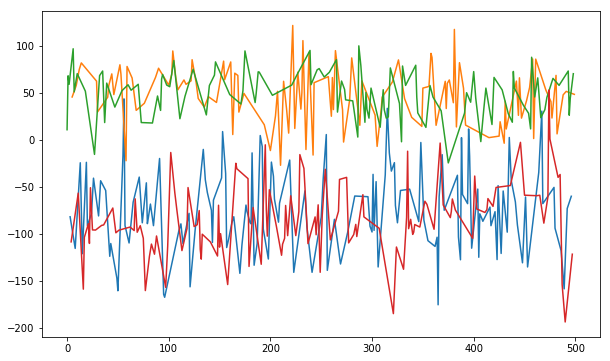

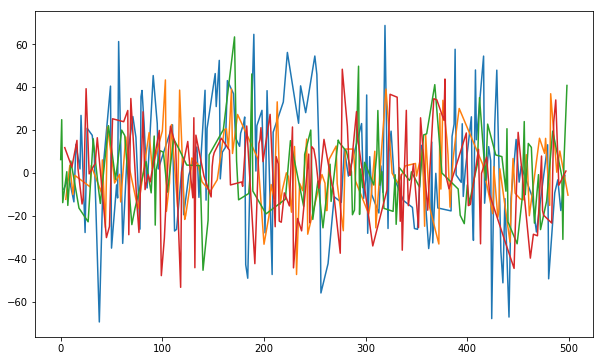

In [118]:
hh.shape
fig,ax = plt.subplots(1,1)
s0t0 = x_inputs_idx == 0
s0t1 = x_inputs_idx == 1
s1t0 = x_inputs_idx == 2
s1t1 = x_inputs_idx == 3

ax.plot(np.argwhere(s0t0), Vohist[0,0,s0t0]/ds)
ax.plot(np.argwhere(s0t1), Vohist[0,0,s0t1]/ds)
ax.plot(np.argwhere(s1t0), Vohist[0,0,s1t0]/ds)
ax.plot(np.argwhere(s1t1), Vohist[0,0,s1t1]/ds)

j = 3
fig,ax = plt.subplots(1,1)
ax.plot(np.argwhere(s0t0), Vhhist[j,0,s0t0]/ds)
ax.plot(np.argwhere(s0t1), Vhhist[j,0,s0t1]/ds)
ax.plot(np.argwhere(s1t0), Vhhist[j,0,s1t0]/ds)
ax.plot(np.argwhere(s1t1), Vhhist[j,0,s1t1]/ds)

#Vohist.shape
hh.shape
#print np.mean(Vohist[0,0,:].reshape((-1,4)),0)
#print np.std(Vohist[0,0,:].reshape((-1,4)),0)/np.sqrt(250)
print np.sum(ho,1)
Vhhist.shape

This works pretty well actually...

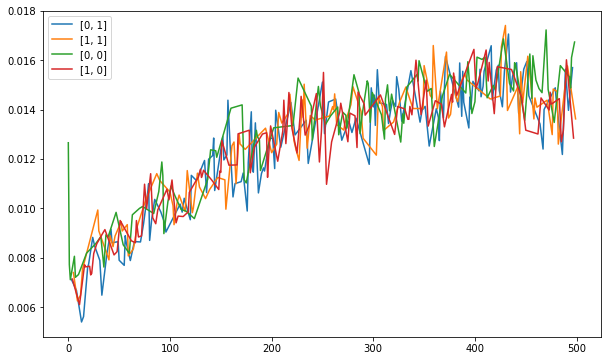

In [119]:
#Plot the output for each of the 4 inputs
#plt.plot(mean_cost)
#mean_cost.shape

fig,ax = plt.subplots(1,1)
ax.plot(np.argwhere(s0t0), mean_output[s0t0], 'C0')
ax.plot(np.argwhere(s0t1), mean_output[s0t1], 'C1')
ax.plot(np.argwhere(s1t0), mean_output[s1t0], 'C2')
ax.plot(np.argwhere(s1t1), mean_output[s1t1], 'C3')
ax.legend({'[0, 0]','[0, 1]','[1, 0]','[1, 1]'})

(1, 10, 500)

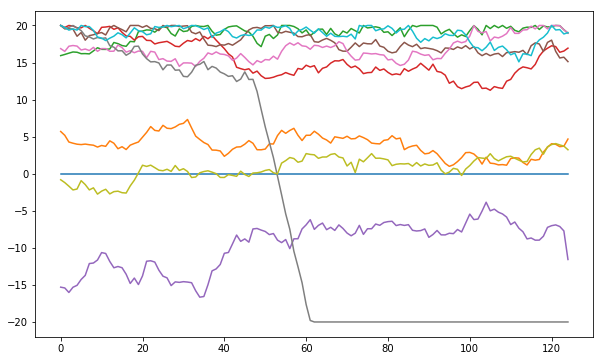

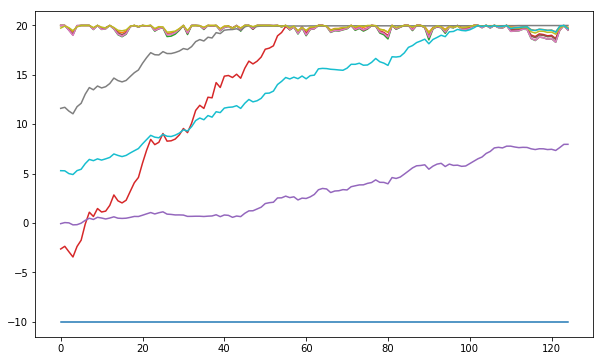

In [120]:
#Plot what the weights are doing
fig,ax = plt.subplots(1,1)
ax.plot(Whist[:,0,range(0,  N,   nI)].T)

fig,ax = plt.subplots(1,1)
ax.plot(Uhist[0,:,range(0,  N,   nI)])
#ax.set_ylim([-1500, 500])
Uhist.shape

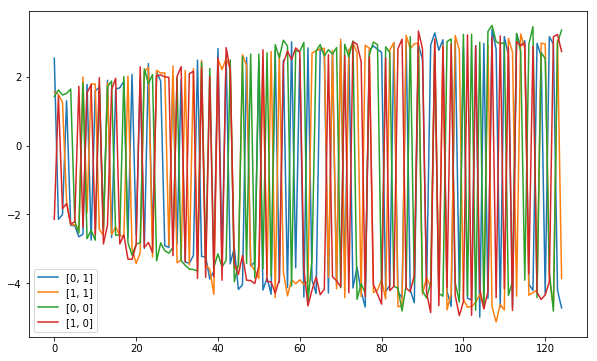

In [121]:
fig,ax = plt.subplots(1,1)
ax.plot(mean_cost[range(0,  N,   nI)], 'C0')
ax.plot(mean_cost[range(1,  N+1, nI)], 'C1')
ax.plot(mean_cost[range(2,  N+2, nI)], 'C2')
ax.plot(mean_cost[range(3,  N+3, nI)], 'C3')
ax.legend({'[0, 0]','[0, 1]','[1, 0]','[1, 1]'})

In [185]:
(vh, hh, vo, ho, sh, sx) = lif.simulate([0,0])
print(np.sum(ho, 1))
(vh, hh, vo, ho, sh, sx) = lif.simulate([0,1])
print(np.sum(ho, 1))
(vh, hh, vo, ho, sh, sx) = lif.simulate([1,0])
print(np.sum(ho, 1))
(vh, hh, vo, ho, sh, sx) = lif.simulate([1,1])
print(np.sum(ho, 1))

[ 22.]
[ 23.]
[ 16.]
[ 20.]


## Checking basic features of the network

I need to:

* make the network balanced. Done, since this only applies to the LSM
* plot activity diagnostics
* implement standard backprop learning, to make sure that works
* turn off the weight learning, and check the RDD rule is doing ok for fixed weights
* Make LSM input the filtered spiking input

### 1. Activity diagnostics

In [50]:
params = ParamsLIF(n = 10)
lif = LIF_3layer(params)

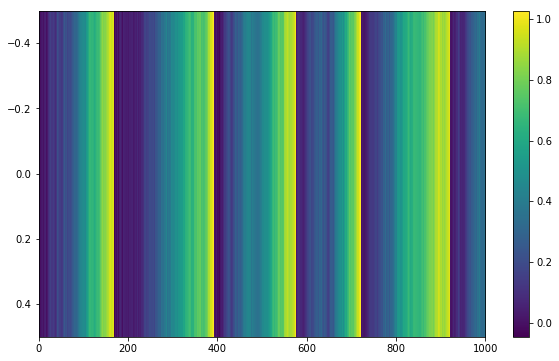

In [57]:
vh, hh, vo, ho, sh, sx = lif.simulate([1,1])
a=plt.imshow(vo, aspect = 'auto')
plt.colorbar(a)

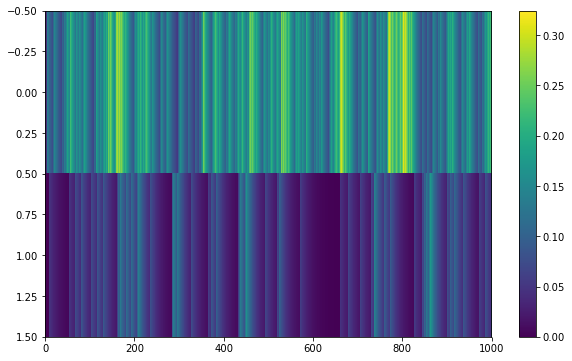

In [4]:
a=plt.imshow(sx, aspect = 'auto')
plt.colorbar(a)

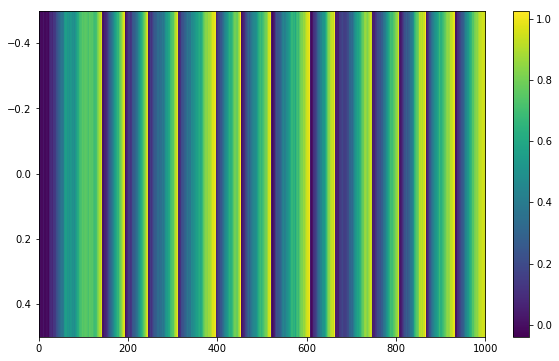

In [5]:
a=plt.imshow(vo, aspect = 'auto')
plt.colorbar(a)

In [4]:
lif.W

array([[  54.73524742,  177.18569684],
       [  70.01149485,  120.48067787],
       [ 144.27385411,   59.61055671],
       [ 117.13743381,   12.19279431],
       [ 135.29011415,  178.81358984],
       [  56.44784004,  189.00637505],
       [ 189.02739855,  165.68069886],
       [ 106.35132401,  155.66292058],
       [ 191.6465091 ,  123.76376557],
       [  85.14546218,   79.07636199]])

In [23]:
lif.U

array([[ 43.17554572, -24.6420282 ,  51.94976389, -24.50573762,
         19.49779564, -51.53652518, -60.83369757,   0.22489635,
         61.45785809,  53.30331854]])

## The theoretical firing rate function and its derivative


In [325]:
mm = 1000
Is = np.linspace(-6, 20, mm)
fI = np.zeros(Is.shape)
V_th = 1
V_r = 0
V_rest = 0
sigma = 20
tau_m = 1

In [326]:
for idx,I in enumerate(Is):
    y_th = (V_th - V_rest - I)/sigma
    y_r = (V_r - V_rest - I)/sigma
    f = lambda u: np.divide(np.multiply(np.exp(-u**2),np.exp(2*y_th*u)-np.exp(2*y_r*u)),u)
    a=quad(f, 0.1, np.infty)[0]
    if np.isfinite(a):
        fI[idx] = 1/(tau_m*a)

/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in multiply


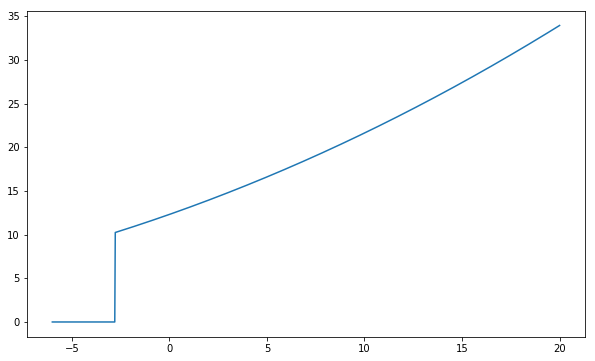

In [329]:
plt.plot(Is, fI)
#plt.plot(Is, np.hstack((np.diff(fI), 0)))

## Compute the firing rate function numerically

In [103]:
#Simulate inputs
N = 1000           # Number of episodes
n = 10              # Number of hidden neurons
no = 1              # Number of output neurons
q = 3               # Number of learnt parameters
tau_s = 0.20        # Time scale for output filter
mu = 1              # Threshold
p = 0.05            # Window size
t = 5               # Time for each episode
eta = .1            # RDD learning rate
epsilon = 0       # Weight learning rate
deltaT = 5         # Size of beta learning mini batches
tau_s = 0.2
sigma = 3
c = 0.25
alpha = 50

params = ParamsLIF(n = n, tau = 10, sigma = sigma, c = c)
lif = LIF_3layer(params, tau_s = tau_s, t = t, alpha = alpha)

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

In [104]:
(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([0,0])

## Input activity

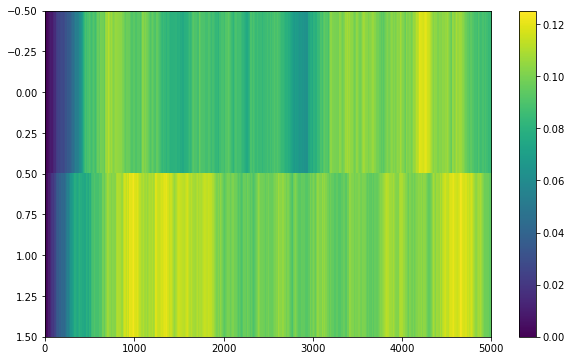

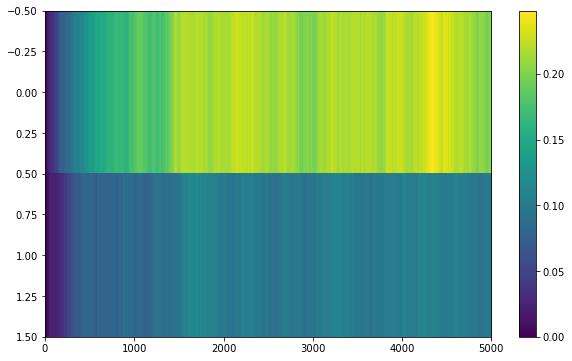

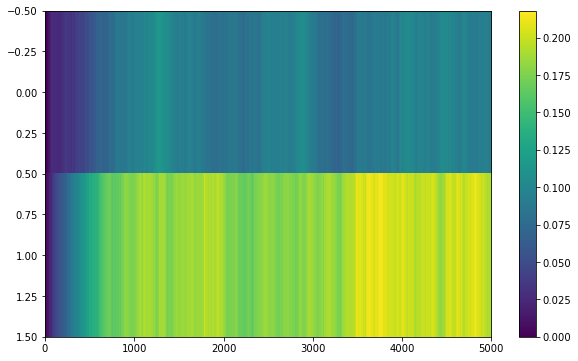

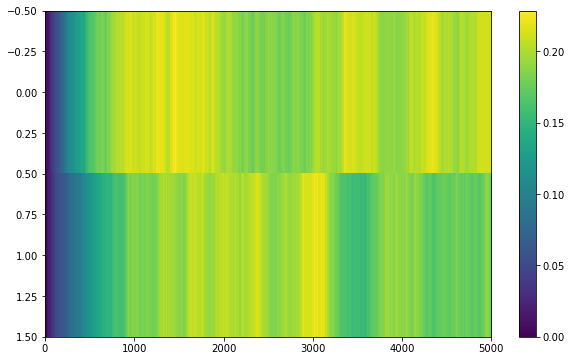

In [105]:
(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([0,0])
fig,ax = plt.subplots(1,1)
a = ax.imshow(sx_full, aspect = 'auto')
plt.colorbar(a)

(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([1,0])
fig,ax = plt.subplots(1,1)
a = ax.imshow(sx_full, aspect = 'auto')
plt.colorbar(a)

(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([0,1])
fig,ax = plt.subplots(1,1)
a = ax.imshow(sx_full, aspect = 'auto')
plt.colorbar(a)

(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([1,1])
fig,ax = plt.subplots(1,1)
a = ax.imshow(sx_full, aspect = 'auto')
plt.colorbar(a)

## Hidden layer activity

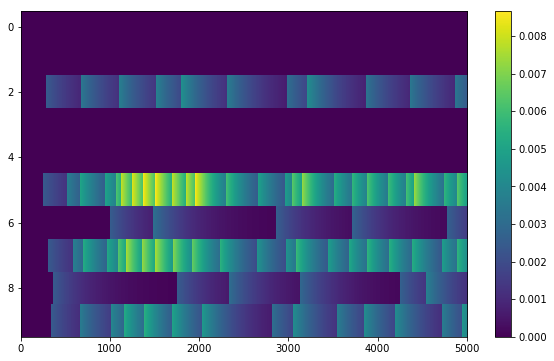

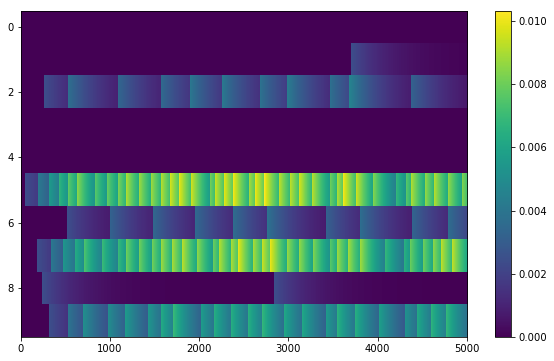

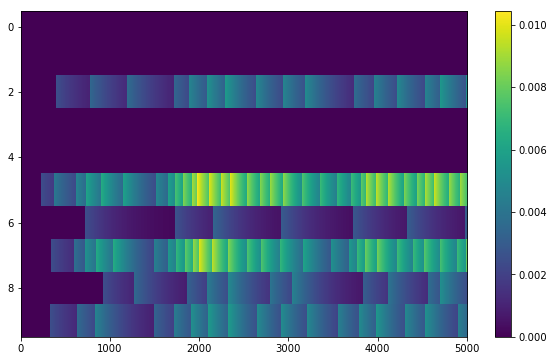

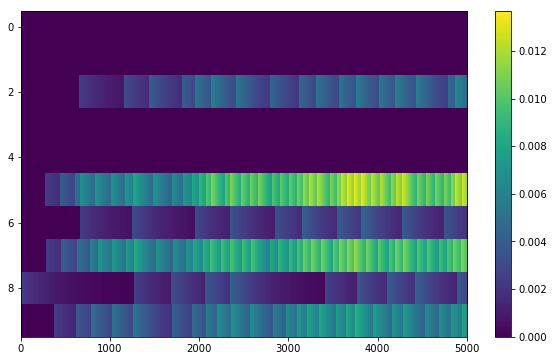

In [106]:
(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([0,0])
fig,ax = plt.subplots(1,1)
a = ax.imshow(sh_full, aspect = 'auto')
plt.colorbar(a)

(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([1,0])
fig,ax = plt.subplots(1,1)
a = ax.imshow(sh_full, aspect = 'auto')
plt.colorbar(a)

(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([0,1])
fig,ax = plt.subplots(1,1)
a = ax.imshow(sh_full, aspect = 'auto')
plt.colorbar(a)

(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([1,1])
fig,ax = plt.subplots(1,1)
a = ax.imshow(sh_full, aspect = 'auto')
plt.colorbar(a)

## Output layer activity

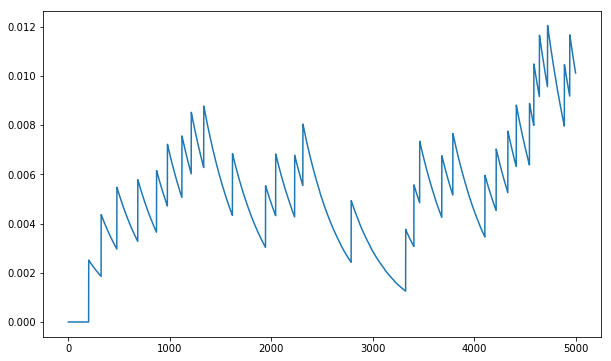

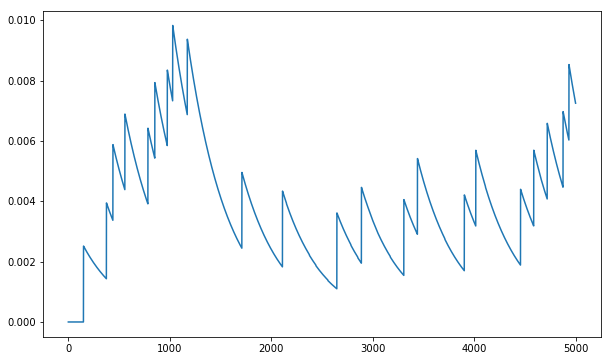

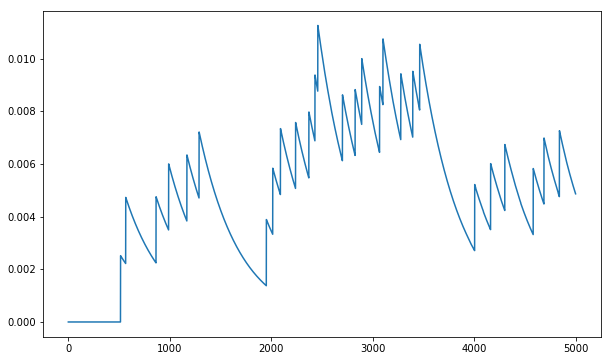

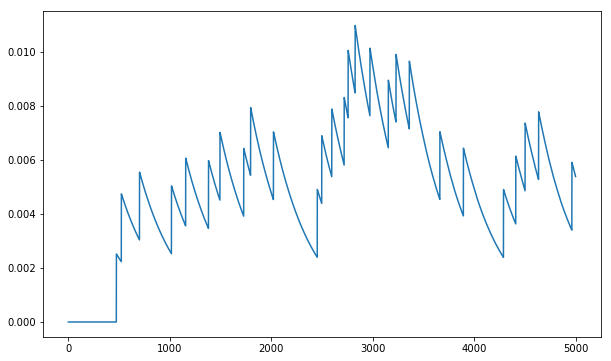

In [107]:
(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([0,0])
fig,ax = plt.subplots(1,1)
so = np.convolve(ho[0,:], exp_filter)[0:ho.shape[1]]    
ax.plot(so)

(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([1,0])
fig,ax = plt.subplots(1,1)
so = np.convolve(ho[0,:], exp_filter)[0:ho.shape[1]]    
ax.plot(so)

(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([0,1])
fig,ax = plt.subplots(1,1)
so = np.convolve(ho[0,:], exp_filter)[0:ho.shape[1]]    
ax.plot(so)

(vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([1,1])
fig,ax = plt.subplots(1,1)
so = np.convolve(ho[0,:], exp_filter)[0:ho.shape[1]]    
ax.plot(so)


## Compute the mean firing rate as a function of mean input

In [125]:
#Create network
#Simulate inputs
N = 1000           # Number of episodes
n = 10              # Number of hidden neurons
no = 1              # Number of output neurons
q = 3               # Number of learnt parameters
tau_s = 0.20        # Time scale for output filter
mu = 1              # Threshold
p = 0.05            # Window size
t = 10               # Time for each episode
eta = .1            # RDD learning rate
epsilon = 0       # Weight learning rate
deltaT = 5         # Size of beta learning mini batches
tau_s = 0.2
sigma = 200
c = 0.5

wmax = 30
Wn = 200

params = ParamsLIF(n = n, tau = 10, sigma = sigma, c = c)
lif = LIF_3layer(params, tau_s = tau_s, t = t)

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

#Vary the weights for one of the inputs
wvals = np.linspace(-wmax, wmax, Wn)
mean_w = np.zeros(Wn)
mean_input = np.zeros(Wn)

#Unit 0
i = 0

for idx,w in enumerate(wvals):
    lif.W[i,0] = w
    (vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate([1,1])
    mean_w[idx] = np.mean(hh[i,:])
    mean_input[idx] = np.mean(lif.W[i,0]*sx_full[0,:] + lif.W[i,1]*sx_full[1,:])

In [126]:
sx_full.shape

(2, 10000)

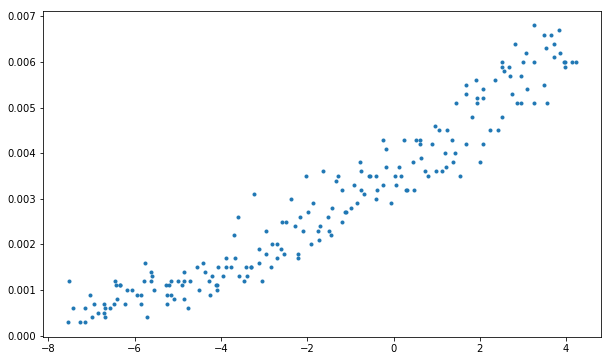

In [127]:
plt.plot(mean_input, mean_w, '.')

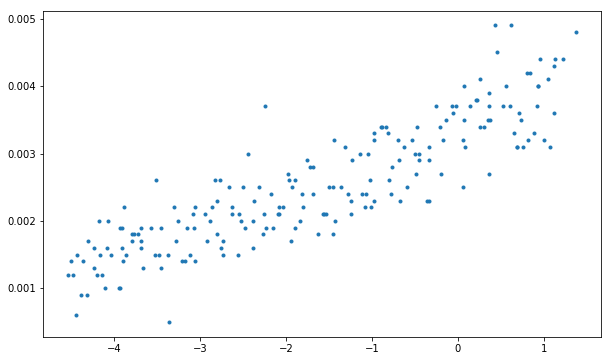

In [124]:
plt.plot(mean_input, mean_w, '.')

## Mean cost surface for a fixed input

In [141]:
#Simulate inputs
N = 1000            # Number of episodes
n = 10              # Number of hidden neurons
no = 1              # Number of output neurons
q = 3               # Number of learnt parameters
tau_s = 0.20        # Time scale for output filter
mu = 1              # Threshold
p = 0.05            # Window size
t = 50              # Time for each episode
eta = .1            # RDD learning rate
epsilon = 0         # Weight learning rate
deltaT = 5          # Size of beta learning mini batches
tau_s = 0.2
sigma = 3
alpha = 50
c = 0.25

wmax = 1000
Wn = 80

def xor(x):
    return x[0] != x[1]

params = ParamsLIF(n = n, tau = 10, sigma = sigma, c = c)
lif = LIF_3layer(params, tau_s = tau_s, t = t, alpha = alpha)

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

#Vary the weights for one of the inputs
wvals = np.linspace(-wmax, wmax, Wn)
mean_w = np.zeros(Wn)
mean_input = np.zeros(Wn)

#Unit 0
i = 1

alpha = 200
beta = -300

x_input = [1,0]

mean_cost = np.zeros(Wn)

for idx,w in enumerate(wvals):
    #Simulate while varying just one of the hidden weights
    lif.W[i,0] = w
    #lif.U[i,0] = w
    (vh_full, hh, vo_full, ho, sh_full, sx_full) = lif.simulate(x_input)
    mean_w[idx] = np.mean(hh[i,:])
    mean_input[idx] = np.mean(lif.W[i,0]*sx_full[0,:] + lif.W[i,1]*sx_full[1,:])

    #Compute cost function
    so = np.convolve(ho[0,:], exp_filter)[0:ho.shape[1]]    
    dcost = alpha if xor(x_input) else beta
    cost = dcost*so

    #Compute mean cost function
    mean_cost[idx] = np.mean(cost)

    #Compute actual mean cost gradient from this (if it exists at all...)

    #Compute the supposed estimated gradient according to learning rules


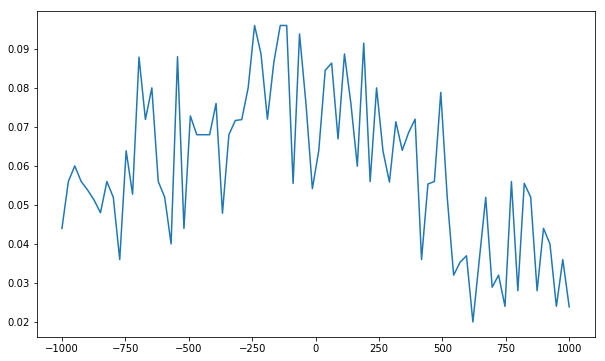

In [142]:
plt.plot(wvals,mean_cost)

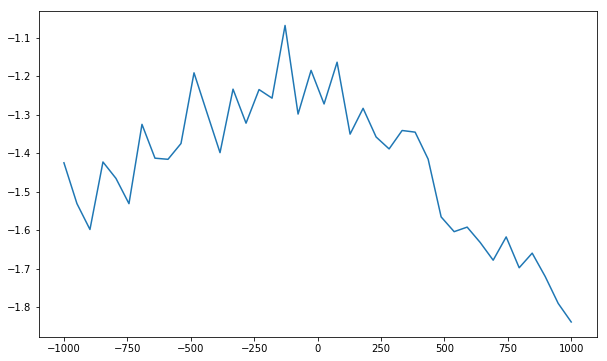

In [134]:
plt.plot(wvals,mean_cost)